In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB



In this notebook a Machine Learning model is trained to predict if a message (sms) is spam or not. Different word representations are tested as well as different Machine Learning models.
The dataset used is from https://www.kaggle.com/uciml/sms-spam-collection-dataset

## Load and re-structure the data

In [100]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [101]:
#process data, by removing unnecessary columns, renaming the remaining and transform the target to binary form

df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

df.columns = ['spam', 'message']
df['spam'] = df['spam'].map({'ham': 0, 'spam': 1})

df.head()

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [102]:
df.describe()

,spam
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Spam Column

In [103]:
df.groupby('spam').describe()

message                                                               
       count unique                                                top freq
spam                                                                       
0       4825   4516                             Sorry, I'll call later   30
1        747    653  Please call our customer service representativ...    4

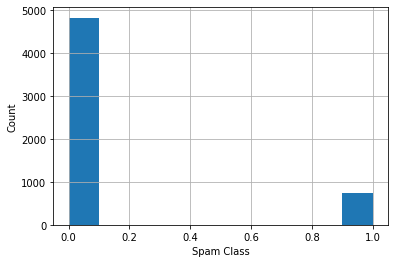

In [104]:

df['spam'].hist()

plt.xlabel('Spam Class')
plt.ylabel('Count')
plt.show()

As we can see, the data is unbalanced, as there are 4825 messages considered not spam and 747 spam messages. This was already expected considering a real case scenario

### Message Column

,spam
message,
"Sorry, I'll call later",30
I cant pick the phone right now. Pls send a message,12
Ok...,10
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4
Okie,4
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4


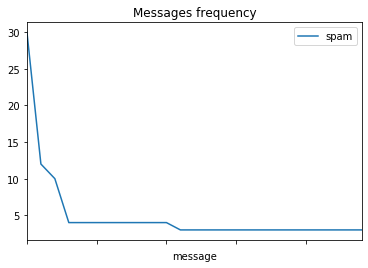

In [105]:
messages_frequency = df.groupby('message').count().sort_values(['spam'], ascending=False)

display(messages_frequency.head(10))


messages_frequency[:25].plot()
plt.gca().axes.xaxis.set_ticklabels([])

plt.title('Messages frequency')
plt.show()


As we can conclude, there are some messages that are duplicated in the dataset. The messages frequency distribution follows a power law behavior

### Check for inconsistency on the data labelling

In [106]:
flag = 0

for msg, m_data in df.groupby('message'):
        spam_labels = m_data['spam'].values

        if 1 in spam_labels and 0 in spam_labels:
            print("Message {} contains both labels: Spam and Not Spam!".format(msg))
            flag = 1
            
if flag == 0:
    print("No inconsistencies were found in the messages labelling!")


No inconsistencies were found in the messages labelling!


### Importance of lenght in the data labelling

In [107]:
df['msg_length'] = df['message'].apply(lambda x: len(x))

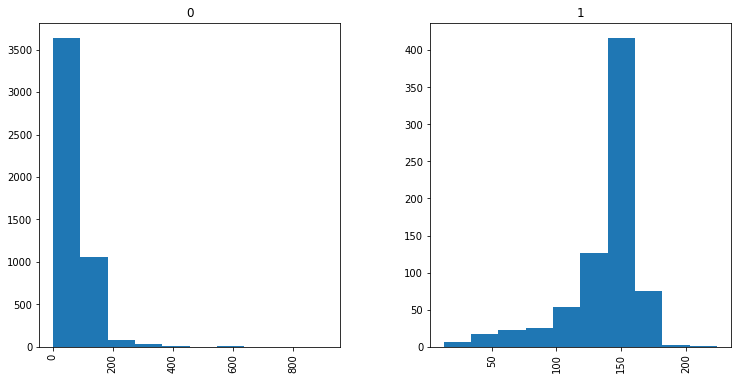

In [108]:

df['msg_length'].hist(by=df['spam'], figsize=(12, 6))

plt.show()

From the plots, we can clearly see that non spam messages are, in general, shorter than the spam messages. Thus, the message length may be an important feature to add in order to detect the spam messages.

In [109]:
df.head()

,spam,message,msg_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [110]:

X_train, X_test, y_train, y_test = train_test_split(df, df['spam'], test_size=0.3)

lenghts_X_train = X_train['msg_length']
lenghts_X_test = X_test['msg_length']

X_train = X_train['message']
X_test = X_test['message']

## Features extraction

Two approaches will be compared: *CountVectorizer* and *TfidfVectorizer*

The *CountVectorizer* counts the occurences of all the words in the training corpus text, for each text document (message/sms)

The *TfidfVectorizer*, besides counting the word frequency in each document, also takes in consideration the words frequency across the different documents. This way, it tries to score the words according to their relevancy. A relevant word should appear frequently in a document but not across all documents.


#### CountVectorizer

In [111]:
#identify all the different words in the training corpus text
count_vect_model = CountVectorizer(decode_error='ignore', stop_words='english').fit(X_train)

#count the number of occurences of each word in the training and test corpus texts
X_train_cnt = count_vect_model.transform(X_train)
X_test_cnt = count_vect_model.transform(X_test)

print('Number of words analysed: ', len(count_vect_model.get_feature_names()))
model = MultinomialNB()
model.fit(X_train_cnt, y_train)

print("Test Accuracy for CountVectorizer:", round(model.score(X_test_cnt, y_test), 3))


Number of words analysed:  6842
Test Accuracy for CountVectorizer: 0.989


#### TfidfVectorizer

In [112]:
#identify all the different words in the training corpus text
tfidf_model = TfidfVectorizer(decode_error='ignore', stop_words='english').fit(X_train)

#count the number of occurences of the most relevant words in the training and test corpus texts
X_train_tfidf = tfidf_model.transform(X_train)
X_test_tfidf = tfidf_model.transform(X_test)

print('Number of words analysed: ', len(tfidf_model.get_feature_names()))
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

print("Test Accuracy for TfidfVectorizer:", round(model.score(X_test_tfidf, y_test), 3))




Number of words analysed:  6842
Test Accuracy for TfidfVectorizer: 0.972


Contrary to what I would expect, the ***CountVectorizer* slightly outperforms *TfidfVectorizer***. This means that, for this dataset, counting directly the word occurences is better than taking also in consideration the word relevancy accross different documents

### Add document length information and compare performance

In [113]:

#identify all the different words in the training corpus text
count_vect_model = CountVectorizer(decode_error='ignore', stop_words='english').fit(X_train)


#count the number of occurences of each word in the training and test corpus texts
X_train_cnt = count_vect_model.transform(X_train)
X_test_cnt = count_vect_model.transform(X_test)

#add length to input
X_train_cnt = hstack((X_train_cnt, lenghts_X_train.values[:,None])).toarray()
X_test_cnt = hstack((X_test_cnt, lenghts_X_test.values[:,None])).toarray()


model = MultinomialNB()
model.fit(X_train_cnt, y_train)

print("Test Accuracy for CountVectorizer:", round(model.score(X_test_cnt, y_test), 3))


Test Accuracy for CountVectorizer: 0.983


By adding the length of the document as input, the performace slightly decreases (from 0.989 to 0.983), therefore, this may not be a useful addition to our model

## Testing different Machine Learning methods

In [114]:

classifiers = [
    [KNeighborsClassifier(), 'KNN'],
    [SVC(), 'SVC'],
    [DecisionTreeClassifier(), 'Decision Tree'],
    [RandomForestClassifier(), 'Random Forest'],
    [MLPClassifier(), 'MLP'],
    [AdaBoostClassifier(), 'AdaBoost'],
    [MultinomialNB(), 'Multinomial Naive Bayes']
]


for c in classifiers:
    model = c[0]
    model.fit(X_train_cnt, y_train)

    print("Test Accuracy for {}: {}".format(c[1], round(model.score(X_test_cnt, y_test), 3)))



Test Accuracy for KNN: 0.919
Test Accuracy for SVC: 0.865
Test Accuracy for Decision Tree: 0.964
Test Accuracy for Random Forest: 0.976
Test Accuracy for MLP: 0.987
Test Accuracy for AdaBoost: 0.975
Test Accuracy for Multinomial Naive Bayes: 0.983


By running and comparing the results of different machine learning classifiers with the default parameterization, we can conclude that the **MLP** and **Multinomial Naive Bayes** are the classifiers with higher test accuracy. Nevertheless, parameter tuning should be performed for improving the results and obtain a better notion of the best machine learning method for spam detection.

As future work, possible improvements would be to perform parameter tuning in the Machine Learning model and make some text preprocessing (remove invalid characters, punctuation, stopwords, etc).